# MAT245 Lab 6

## Linear least squares regression - quick review 

Recall that in a linear least squares regression problem, we have a matrix $X$ whose rows represent, say, measurements from some sensors in an experiemnt. If we have a single sensor and conduct $m$ experiments, $X$ looks like:

$$
\begin{pmatrix}
  1 & x_1 \\
  1 & x_2 \\
  \vdots & \vdots \\
  1 & x_m
\end{pmatrix}
$$

For each of the $m$ experiments we have some observed output $y_i$, and we want to model this output as a linear function of the inputs. So if $\hat{y}$ denotes the output of our model, 

$$
  \hat{y}_i = \theta_0 + \theta_1 x_i.
$$

For a given choice $\theta = (\theta_0, \theta_1)$ of parameters, we can measure how "good" our predictions are by computing

$$
  \| \hat{y} - y \| = \| X\theta - y \|.
$$

One way of selecting a "good" choice of $\theta$ is to minimize the mean-squared error $\frac{1}{m} \| X \theta - y\|$. In other words, we want to find

$$
  \mathrm{argmin}_\theta \| X\theta - y\|.
$$


## The pseudo-inverse

The Moore-Penrose pseudo-inverse of an $m\times n$ matrix $X$ is the unique $n \times m$ matrix, usually denoted $X^+$, that satisfies

- $(X^+ X)^T = X^+ X$
- $(X X^+)^T = X X^+$
- $X^+ X X^+ = X^+$
- $XX^+ X = X$

It can be shown that if $X$ has the singular value decomposition

$$ X = U \Sigma V^T$$

then $X^+$ decomposes as

$$
X^+ = V \Sigma^+ U^T
$$

where $\Sigma^+ = \mathrm{diag}\left(\frac{1}{\sigma_1}, \dots, \frac{1}{\sigma_r}\right)$ is an $n\times m$ matrix. The pseudo-inverse is particularly useful because because it provides a solution to the least squares problem:

$$
X^+ b = \mathrm{argmin}_{x} \|X\theta - y\|.
$$

$X^+$ satisfies a convenient limit identity:

$$
X^+ = \lim_{\delta \downarrow 0} ~((X^T X + \delta^2 I)^{-1}X^T).
$$

This allows us to easily approximate $X^+$, since for small $\delta$ values, we have

$$
X^+ \approx (X^TX + \delta^2 I)^{-1}X^T.
$$

Let's use the pseudo-inverse approoach to do a least-squares regression on a couple subsets of the Boston data. To get started, we can plot median house price as a against each of the input variables to see which relationships might be amenable to linear regression analysis:

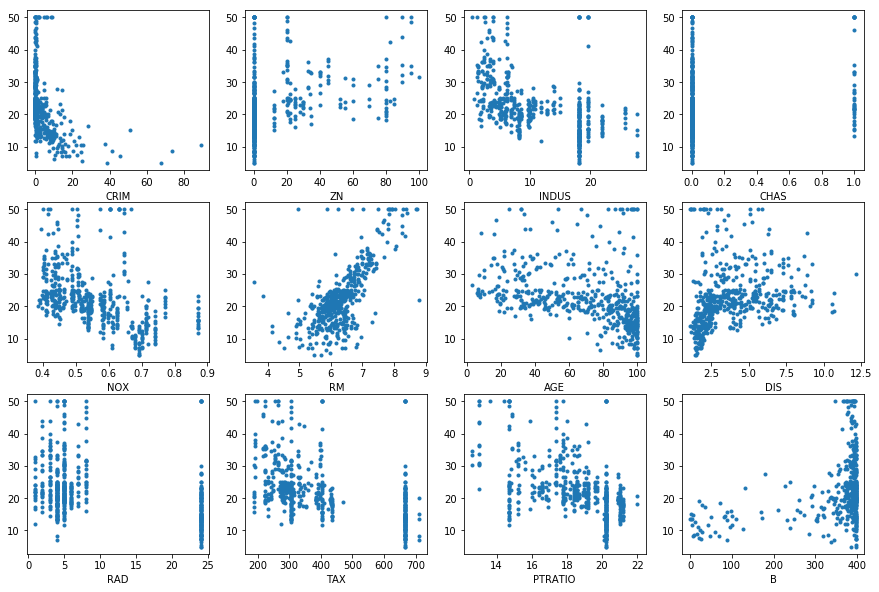

In [98]:
from sklearn import datasets
import matplotlib.pyplot as plt

bost = datasets.load_boston()
fig = plt.figure(figsize=(15, 10))

for i in range(0, 12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.set_xlabel(bost.feature_names[i])
    xs, ys = bost.data[:, i], bost.target
    plt.scatter(xs, ys, marker='.')
    
plt.show()

## Goals

- Use the plots above to choose a column of data from the boston dataset suitable for regression analysis.   
- Use the SVD formula to write a function that computes the pseudo-inverse $X^+$ of a 2D `numpy` array $X$.
- Solve the linear regression problem for your data (ie find $\theta$) using your pseudo-inverse implementation, and plot the resulting function against the data you chose. 
- Now write a function that takes $X$ and $\delta$ and returns the $\delta$-approximation to $X^+$ using the limit formula above. 
- Solve the linear regression problem again using your approximations for $\delta = 0.5, 0.1, 0.01$ and plot the results.  

np inv: 
[[-1.17678014  0.59940787  1.5856213 ]
 [ 3.74846031 -2.67982461 -0.29117199]
 [-2.87594252  3.30758233 -0.97490394]]
pinv: 
[[-1.17678014  0.59940787  1.5856213 ]
 [ 3.74846031 -2.67982461 -0.29117199]
 [-2.87594252  3.30758233 -0.97490394]]
[-34.67062078   9.10210898]


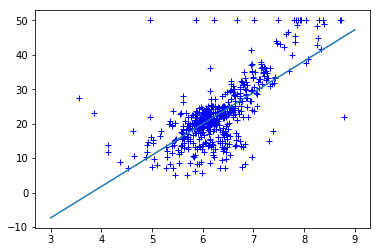

In [99]:
# the pseudo inverse calcutation
import numpy as np
%matplotlib inline
def pinv(mat):
    U, s, V = np.linalg.svd(mat)
    Ut = U.transpose()
    Vt = V.transpose()
    m = Vt.shape[1]
    n = Ut.shape[0]
    Sinv = np.zeros((m, n))
    for i in range(len(s)):
        Sinv[i,i] = 1/s[i]
    return Vt.dot(Sinv).dot(Ut)

mat = np.random.rand(3,3)
print "np inv: "
print np.linalg.inv(mat)
print "pinv: "
print pinv(mat)

# we choose RM, the 5th column
xs = bost.data[:, 5]
xs.reshape(-1,1)
Xs = np.hstack((np.ones((bost.data.shape[0],1)),xs.reshape(-1,1)))

X_plus = pinv(Xs)
theta = X_plus.dot(ys)
print theta

x = range(3, 10, 1)
y =  [k * theta[1] + theta[0] for k in x]

plt.figure(1)
plt.plot(bost.data[:, 5], ys, "b+")
plt.plot(x, y)
plt.show()


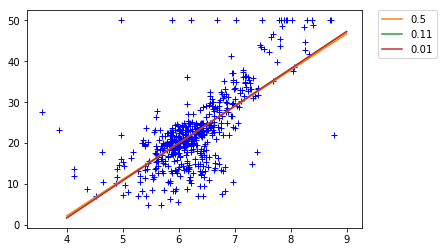

In [71]:
def ppinv(X, delta):
    return np.linalg.inv(X.transpose().dot(X)+delta*delta*np.identity(X.shape[1])).dot(X.transpose())


X_pluses =  [ppinv(Xs, 0.5) , ppinv(Xs, 0.1) ,ppinv(Xs, 0.01)]
thetas = [ x_plus.dot(ys) for x_plus in X_pluses]


plt.figure(1)
plt.plot(bost.data[:, 5], ys, "b+")

x = range(4, 10, 1)

y =  [k * thetas[0][1] + thetas[0][0] for k in x]
plt.plot(x, y, 'C1', label="0.5")
y =  [k * thetas[1][1] + thetas[1][0] for k in x]
plt.plot(x, y, 'C2', label="0.11")
y =  [k * thetas[2][1] + thetas[2][0] for k in x]
plt.plot(x, y, 'C3', label="0.01")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
    



## Validating your models.

When we train a model on some data, we'd like to have an idea of how well our model might generalize to new, unseen samples. Suppose our starting dataset has $m$ entries. The simplest approach to validation is to:

- Split these $m$ samples into two subsets: training and validation. A common choice is to do a random 70%/30% split between training/validation. 
- Train the model on the training set.
- Then compute the mean squared error between the known targets and our model's predictions on the validation set.

Now let's do a regression on the `sklearn` diabetes dataset, and use the simple validation procedure above to test generalizability of our model. First we plot the target variable, which represents how much a patient's diabetes has worsened in the past year, against each of the input variables. (See the `diab['DESCR']` field for more information on the individual inputs.)

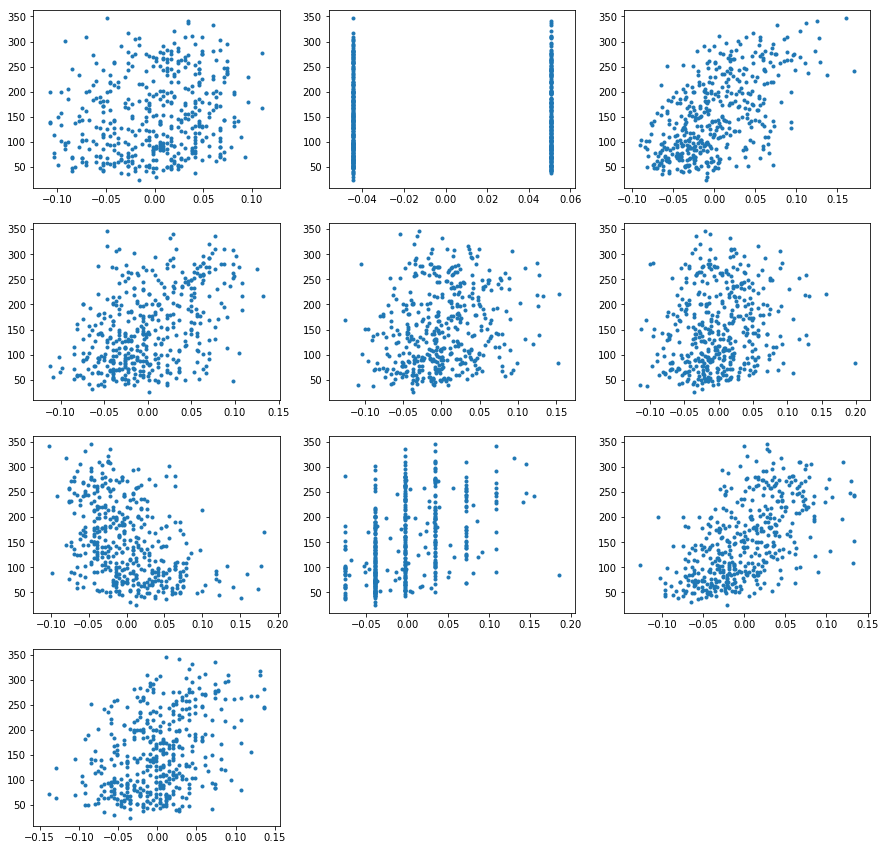

In [72]:
diab = datasets.load_diabetes()

fig = plt.figure(figsize=(15, 15))

for i in range(0, 10):
    ax = fig.add_subplot(4, 3, i + 1)
    # ax.set_xlabel(diab['feature_names'][i])
    xs, ys = diab.data[:, i], diab.target
    plt.scatter(xs, ys, marker='.')
    
plt.show()

## Goals:

- Use the plots above to choose a column from the diabetes dataset that looks amendable to a linear regression analysis. 
- Once you've chosen your target column, do a 70/30 split on the inputs and targets to divide it into training and test sets. Make sure the input and target rows match. Use `sklearn.cross_validation.train_test_split`.
- Use you SVD based pseudo-inverse function from part 1 to train a linear least squares model on the training data. 
- Use your trained model to generate predictions on the validation set. Compute the mean-squared error compared to the true targets. (The `sklearn.metrics` library might be useful here.)
- Repeat the last two steps with a $\delta$-approximation to the pseudo-inverse. How does the validation error compare?

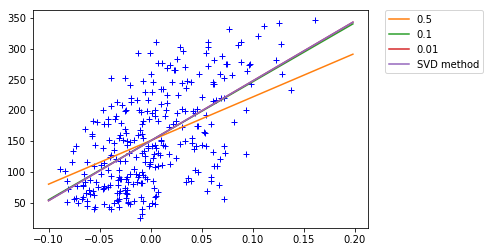

array([  22584.95609165,  918831.3732158 ])

In [89]:
from sklearn.model_selection import train_test_split
y = ys
X = np.hstack((np.ones((diab.data[:, i].shape[0], 1)) , diab.data[:, 2].reshape(-1,1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# the svd one
pinv(X_train)
# delta one
X_pluses =  [ppinv(X_train, 0.5) , ppinv(X_train, 0.1) ,ppinv(X_train, 0.01), pinv(X_train)]
thetas = [ x_plus.dot(y_train) for x_plus in X_pluses]

plt.figure(2)
plt.plot(X_train[ :,1], y_train, "b+")

x = np.array(range(-50, 100, 1))
x = x/ float(500)

y =  [k * thetas[0][1] + thetas[0][0] for k in x]
plt.plot(x, y, 'C1', label="0.5")
y =  [k * thetas[1][1] + thetas[1][0] for k in x]
plt.plot(x, y, 'C2', label="0.1")
y =  [k * thetas[2][1] + thetas[2][0] for k in x]
plt.plot(x, y, 'C3', label="0.01")
y =  [k * thetas[3][1] + thetas[3][0] for k in x]
plt.plot(x, y, 'C4', label="SVD method")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
    
thetas[1]**2


In [102]:
J_train = [ np.sum((X_train.dot(theta)-y_train)**2)/(y_train.shape[0]) for theta in thetas  ]
J_test = [ np.sum((X_test.dot(theta)-y_test)**2)/(y_test.shape[0]) for theta in thetas  ]
print J_train
print J_test


[4034.2398906437556, 3876.4921148997059, 3876.0285521359074, 3876.0285043933404]
[4004.1094224676799, 3929.7055958275018, 3934.018327600168, 3934.0672763273196]
